In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [2]:
 warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('20_0.csv')

In [4]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))#导入数据

(2234, 10)
340


In [5]:
from sklearn.model_selection import train_test_split

X, y = data_temp[:, 1:], data_temp[:, 0]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)#划分训练集
sum(y_test)#测试集里多少个萧条样本

102.0

In [6]:
sum(y_train)#训练集里多少个萧条样本

238.0

In [7]:
sum(y_test)#测试集里多少个萧条样本

102.0

In [8]:
# upsampling
print('Number of recession samples before:',X_train[y_train==1].shape[0])
print('Number of normal samples before:',X_train[y_train==0].shape[0])
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                   replace=True,
                                   n_samples = X_train[y_train==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 238
Number of normal samples before: 1325
Number of recession samples after: 1325


In [9]:
X_train_bal = np.vstack((X_train[y_train==0], X_upsampled))

In [10]:
y_train_bal = np.hstack((y_train[y_train==0], y_upsampled))

In [11]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(2650, 9)
(2650,)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_bal)
X_test_std = stdsc.transform(X_test)#标准化

In [14]:
##LR
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1))

In [15]:
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.82170543 0.83333333 0.82706767 0.81318681 0.84363636 0.76428571
 0.83754513 0.80985915 0.83018868 0.81751825]
CV accuracy: 0.820 +/- 0.021


In [16]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_std, y_train_bal)
y_pred_lr2 = lr.predict(X_test_std)

In [17]:
lr.coef_

array([[-0.53630598, -1.28950271,  0.7505465 ,  0.16573055,  0.36364901,
        -1.97788019,  0.36943773,  0.11470004, -0.25103287]])

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_lr2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[448 121]
 [ 16  86]]
Precision: 0.415
Recall: 0.843
F1: 0.557


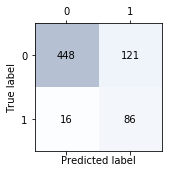

In [19]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [20]:
## Tree pipeline
pipe_tree = make_pipeline(StandardScaler(),
                        #PCA(n_components=3),
                         DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1))

In [21]:
scores = cross_val_score(estimator = pipe_tree,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.96028881 0.94964029 0.94964029 0.97794118 0.93992933 0.92198582
 0.93238434 0.92592593 0.94202899 0.9352518 ]
CV accuracy: 0.944 +/- 0.016


In [22]:
pipe_tree.fit(X_train_bal, y_train_bal)
y_pred_tree = pipe_tree.predict(X_test)
print('Train Accuracy: %.3f' % pipe_tree.score(X_train_bal, y_train_bal))
print('Test Accuracy: %.3f' % pipe_tree.score(X_test, y_test))#忽略该块程序即可，为了可视化tree没用pipeline

Train Accuracy: 0.958
Test Accuracy: 0.888


In [23]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=10, 
                              random_state=1)
tree.fit(X_train_std, y_train_bal)
y_pred_tree2 = tree.predict(X_test_std)

In [24]:
#tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_tree2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[543  26]
 [ 29  73]]
Precision: 0.737
Recall: 0.716
F1: 0.726


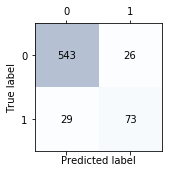

In [25]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

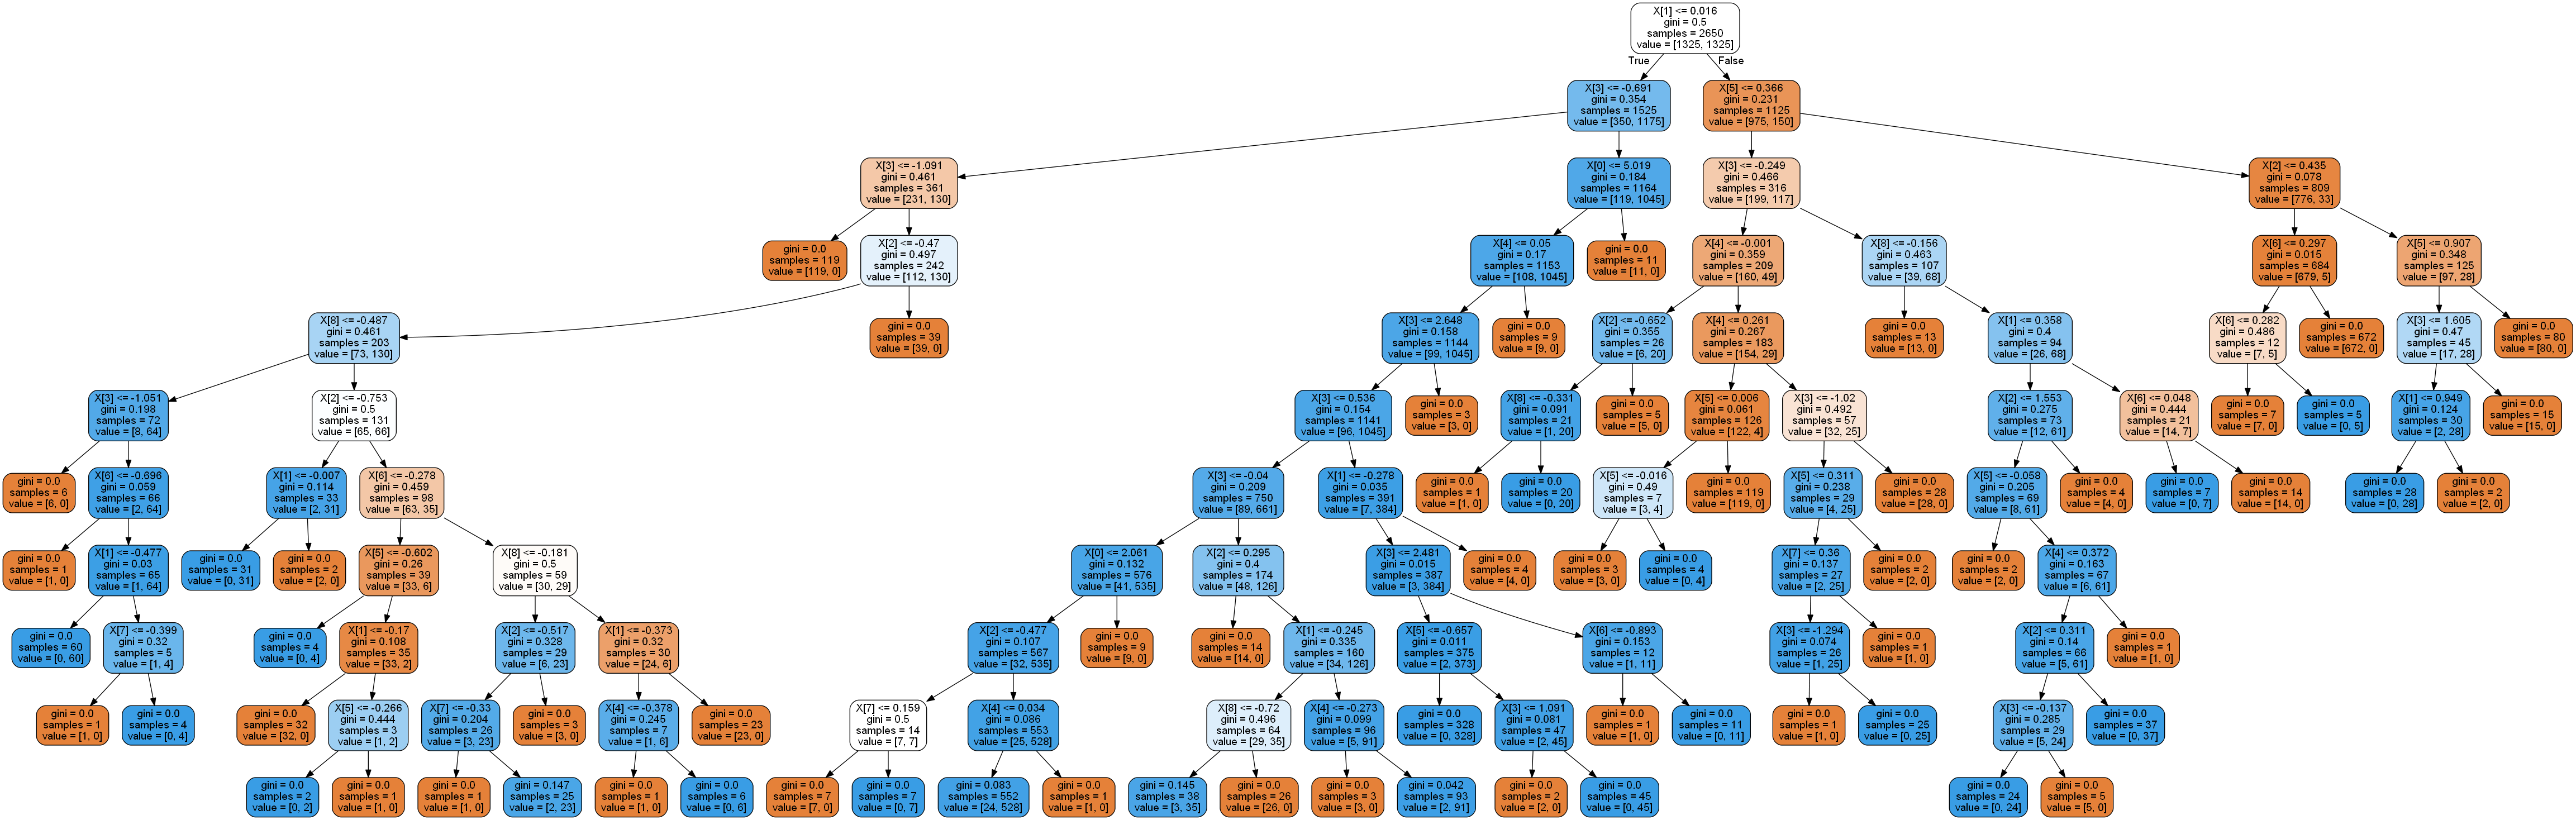

In [26]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('Pic/tree20_0.png') 

from IPython.display import Image
Image(filename='Pic/tree20_0.png', width=600) 

In [27]:
## SVC pipeline
pipe_svc = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                         SVC(kernel='rbf',random_state=1))

In [28]:
scores = cross_val_score(estimator = pipe_svc,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.86692015 0.86764706 0.82575758 0.8880597  0.8030303  0.80882353
 0.87121212 0.85294118 0.86692015 0.84528302]
CV accuracy: 0.850 +/- 0.027


In [29]:
svm = SVC(kernel='rbf', random_state=1, C=0.01, gamma=0.5) #gamma
svm.fit(X_train_std, y_train_bal)
y_pred_svc2 = lr.predict(X_test_std)

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_svc2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[448 121]
 [ 16  86]]
Precision: 0.415
Recall: 0.843
F1: 0.557


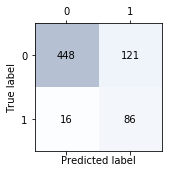

In [31]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()